In [1]:
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob

In [2]:
files = glob.glob("Sunderbans/*.tif")

In [3]:
dates=[]
links=[]
for f in files:
    dates.append(pd.to_datetime(f.split('/')[1].split('.')[0]))
    links.append(f)

data=pd.DataFrame(list(zip(dates,links)),columns=['date','links'])    

In [4]:
data['key']=data.date.apply(lambda x: str(x.year)+'-'+str(x.month))
data['key_q']=data.date.apply(lambda x: str(x.year)+'-'+str(x.quarter))
data['key_y']=data.date.apply(lambda x: str(x.year))

In [5]:
data

,date,links,key,key_q,key_y
0,2014-01-01,Sunderbans/20140101.tif,2014-1,2014-1,2014
1,2014-01-09,Sunderbans/20140109.tif,2014-1,2014-1,2014
2,2014-01-17,Sunderbans/20140117.tif,2014-1,2014-1,2014
3,2014-01-25,Sunderbans/20140125.tif,2014-1,2014-1,2014
4,2014-02-02,Sunderbans/20140202.tif,2014-2,2014-1,2014
...,...,...,...,...,...
271,2019-11-25,Sunderbans/20191125.tif,2019-11,2019-4,2019
272,2019-12-03,Sunderbans/20191203.tif,2019-12,2019-4,2019
273,2019-12-11,Sunderbans/20191211.tif,2019-12,2019-4,2019
274,2019-12-19,Sunderbans/20191219.tif,2019-12,2019-4,2019


In [6]:
def calcs(x,threshold):
    x=np.where(x>=threshold,1,0)
    return x.sum(), np.round(100*np.sum(x)/(x.shape[0]*x.shape[1]),2)

def compute_stats(links):
    imgs=[]
    for i in links:
        imgs.append(tifffile.imread(i))
    imgs = np.asarray(imgs)
    med = np.nanmedian(imgs, axis=0)
    return calcs(med,0.5)

def fetch_results(keys,freq):
        key='key'
        if freq=='q':
            key='key_q'
        elif freq=='y':
            key='key_y'
            
        temp=[]
        for k in keys:
            x,y = compute_stats(data[data[key]==k].links.values)
            temp.append([pd.to_datetime(k, errors = 'coerce'),x,y])    
        return pd.DataFrame(temp, columns=['date','total','percent'])    

In [7]:
results=fetch_results(data.key.unique(),'m')
results_q=fetch_results(data.key_q.unique(),'q')
results_y=fetch_results(data.key_y.unique(),'y')

/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


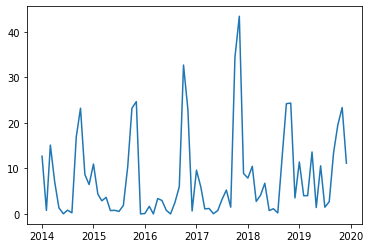

In [34]:
plt.plot(results.percent)

In [10]:
results_q.set_index('date', inplace=True)
results.set_index('date', inplace=True)

In [17]:
results.diff(24).groupby([(results.index.year),(results.index.month)]).mean().dropna()

total  percent
date date                 
2016 1    -2621.0   -12.58
     2      187.0     0.89
     3    -3149.0   -15.11
     4     -751.0    -3.60
     5      338.0     1.63
     6      155.0     0.75
     7     -171.0    -0.82
     8      469.0     2.25
     9    -2289.0   -10.98
     10    1974.0     9.47
     11    2979.0    14.30
     12   -1211.0    -5.81
2017 1     -282.0    -1.35
     2      319.0     1.53
     3     -372.0    -1.78
     4     -509.0    -2.45
     5     -143.0    -0.68
     6      -12.0    -0.06
     7      544.0     2.61
     8      706.0     3.38
     9    -1851.0    -8.88
     10    2327.0    11.16
     11    3907.0    18.75
     12    1848.0     8.87
2018 1     1621.0     7.78
     2     1830.0     8.78
     3      570.0     2.74
     4      157.0     0.75
     5      791.0     3.79
     6       -7.0    -0.04
     7      236.0     1.13
     8     -475.0    -2.27
     9     1366.0     6.56
     10   -1767.0    -8.48
     11     290.0     1.39
     12     599.0     2.88
2019 1      377.0     1.80
     2     -395.0    -1.90
     3      606.0     2.91
     4     2586.0    12.41
     5      284.0     1.36
     6     2049.0     9.83
     7     -353.0    -1.69
     8     -536.0    -2.57
     9     2495.0    11.97
     10   -3096.0   -14.85
     11   -4177.0   -20.04
     12     474.0     2.27

In [12]:
results.diff(12).groupby([(results.index.year),(results.index.quarter)]).mean().dropna()

total    percent
date date                        
2015 1     -720.333333  -3.456667
     2     -221.000000  -1.056667
     3     -365.000000  -1.746667
     4      664.333333   3.186667
2016 1    -1140.666667  -5.476667
     2      135.000000   0.650000
     3     -298.666667  -1.436667
     4      583.000000   2.800000
2017 1     1029.000000   4.943333
     2     -356.333333  -1.713333
     3       98.333333   0.473333
     4     2111.000000  10.126667
2018 1      311.333333   1.490000
     2      670.000000   3.213333
     3      277.333333   1.333333
     4    -2403.666667 -11.530000
2019 1     -115.333333  -0.553333
     2      969.666667   4.653333
     3      258.000000   1.236667
     4      137.333333   0.656667

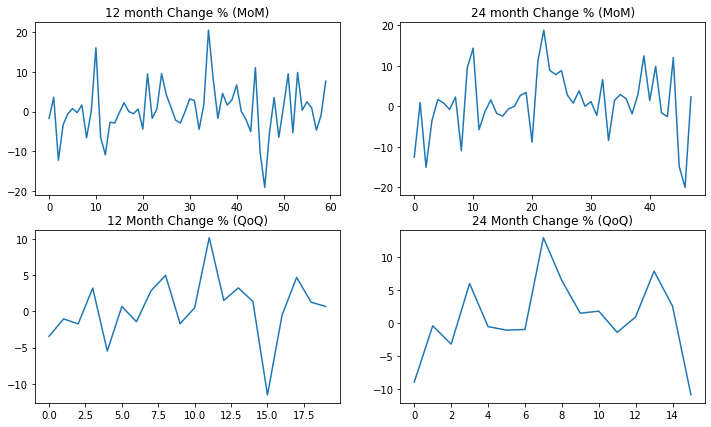

In [37]:
fig, ax=plt.subplots(2,2, figsize=(12,7))
ax[0][1].plot(results.diff(24).groupby([(results.index.year),(results.index.month)]).mean().dropna()['percent'].values)
ax[0][1].set_title("24 month Change % (MoM)");

ax[0][0].plot(results.diff(12).groupby([(results.index.year),(results.index.month)]).mean().dropna()['percent'].values)
ax[0][0].set_title("12 month Change % (MoM)");

ax[1][0].plot(results.diff(12).groupby([(results.index.year),(results.index.quarter)]).mean().dropna()['percent'].values)
ax[1][0].set_title('12 Month Change % (QoQ)');

#ax[1][1].plot(results_y.percent.diff(1))
ax[1][1].plot(results.diff(24).groupby([(results.index.year),(results.index.quarter)]).mean().dropna()['percent'].values)
ax[1][1].set_title('24 Month Change % (QoQ)');

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [ ]:
plot_pacf(results['total'], lags=14)

In [ ]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [ ]:
for d in range(1, 14):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(results.total.diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(results.total.diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
    
    print()

In [ ]:
model = ARIMA(endog = results.total.diff(2).dropna(), # endog = Y variable
              order = (2,0,2))
arima_1_4_0 = model.fit()
preds = arima_1_4_0.predict()



In [ ]:
mean_squared_error(results.total.diff(2).dropna(), preds)

In [ ]:

arima_1_4_0.forecast(6)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(results_q.total.diff(6).dropna(), color = 'blue')
plt.plot(preds, color = 'orange')
#plt.title(label = 'Bus Ridership with ARIMA(1,4,0) Predictions', fontsize=18)
plt.show();

In [ ]:
from fbprophet import Prophet

In [ ]:
res=.diff(4).dropna()

In [ ]:
results.reset_index(inplace=True)

In [ ]:
temp=results.iloc[:,[0,2]]
temp.columns = ['ds', 'y']

In [ ]:
temp

In [ ]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True)
m.fit(temp)

In [ ]:
future = m.make_future_dataframe(periods=24, freq='M')
print(future)

In [ ]:
forecast = m.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
plt.plot(results.percent, color = 'blue')
plt.plot(forecast.yhat, color = 'orange')

In [ ]:
pd.plotting.register_matplotlib_converters()
# known issue in pandas right now
# github issue: https://github.com/facebook/prophet/issues/999

m.plot(forecast);

In [ ]:
m.plot_components(forecast);

In [ ]:
im = tifffile.imread('trials/rwanda90.tif')



In [ ]:
one=tifffile.imread('climate/20191203.tif')
two=tifffile.imread('climate/20191211.tif')
three=tifffile.imread('climate/20191219.tif')
four=tifffile.imread('climate/20191227.tif')


In [ ]:
imgs = [one,two,three,four]

v


In [ ]:
med = np.nanmedian(imgs, axis=0)

In [ ]:
100*np.isnan(im).sum()/(im.shape[0]*im.shape[1])

In [ ]:
med2 = np.nanmedian(imgs, axis=0)

In [ ]:
100*np.isnan(med2).sum()/(med2.shape[0]*med2.shape[1])

In [ ]:
plt.imshow(np.where(im>=0.6,1,0), cmap='viridis')

In [ ]:
plt.imshow(med2, cmap='viridis_r')

In [ ]:
def calcs(x,threshold):
    x=np.where(x>=threshold,1,0)
    return x.sum()*1000, np.sum(x)/(x.shape[0]*x.shape[1])

In [ ]:
calcs(im,0.5)

In [ ]:
calcs(med2,0.5)`

In [ ]:
17194000/6247000